# Figures for paper

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *
from single_cell import *
from brainspan import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *
from disorders_data import *
from disorders import *

In [10]:
%%R 
source("../code/fig_extended.R")
library(plot3D)
library(gridExtra)
library(png)


https://r-graphics.org

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [3]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [4]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

---

### 3D plot with components as axes

In [5]:
def get_xyz_corrs(version):
    hcp_xyz = fetch_hcp()['info'].loc[:180,['id','x-cog','y-cog','z-cog']].set_index('id').set_axis(['x','y','z'],axis=1)
    corrs = version.clean_scores().join(hcp_xyz).corr().iloc[3:,:3]
    return corrs.apply(lambda x: x * [1,-1,1], axis=0)

xyz_corrs = get_xyz_corrs(dme_3d_ds5)

In [6]:
xyz_corrs_plot = (xyz_corrs
                  .applymap(lambda x: np.round(x,2))
                  .loc[['y','z','x'],:]
                  .set_axis([
                      'Anterior-to-Posterior',
                      'Ventral-to-Dorsal',
                      'Medial-to-Lateral'
                  ], axis=0)
                  )
xyz_corrs_plot

,C1,C2,C3
Anterior-to-Posterior,0.64,-0.50,0.03
Ventral-to-Dorsal,0.54,0.58,-0.16
Medial-to-Lateral,0.03,-0.08,0.38


In [7]:
xyz_corrs_norm = xyz_corrs / np.linalg.norm(xyz_corrs, axis=0)
from math import pi
angles = round(np.arccos(np.clip(xyz_corrs_norm.T @ xyz_corrs_norm, -1,1)) * 180/pi)
angles = angles.astype('int').astype('str') + '°'
angles

,C1,C2,C3
C1,0°,91°,99°
C2,91°,0°,115°
C3,99°,115°,0°


              [,1]       [,2]       [,3]       [,4]
[1,]  1.126272e+00 -2.1016513  3.6401669 -1.2133890
[2,]  1.705454e+00  0.2284876 -0.3957521  0.1319174
[3,] -1.598622e-16  2.3407326  1.3514226 -0.4504742
[4,] -2.940451e-01 -0.1832386 -5.5513192  2.8504397


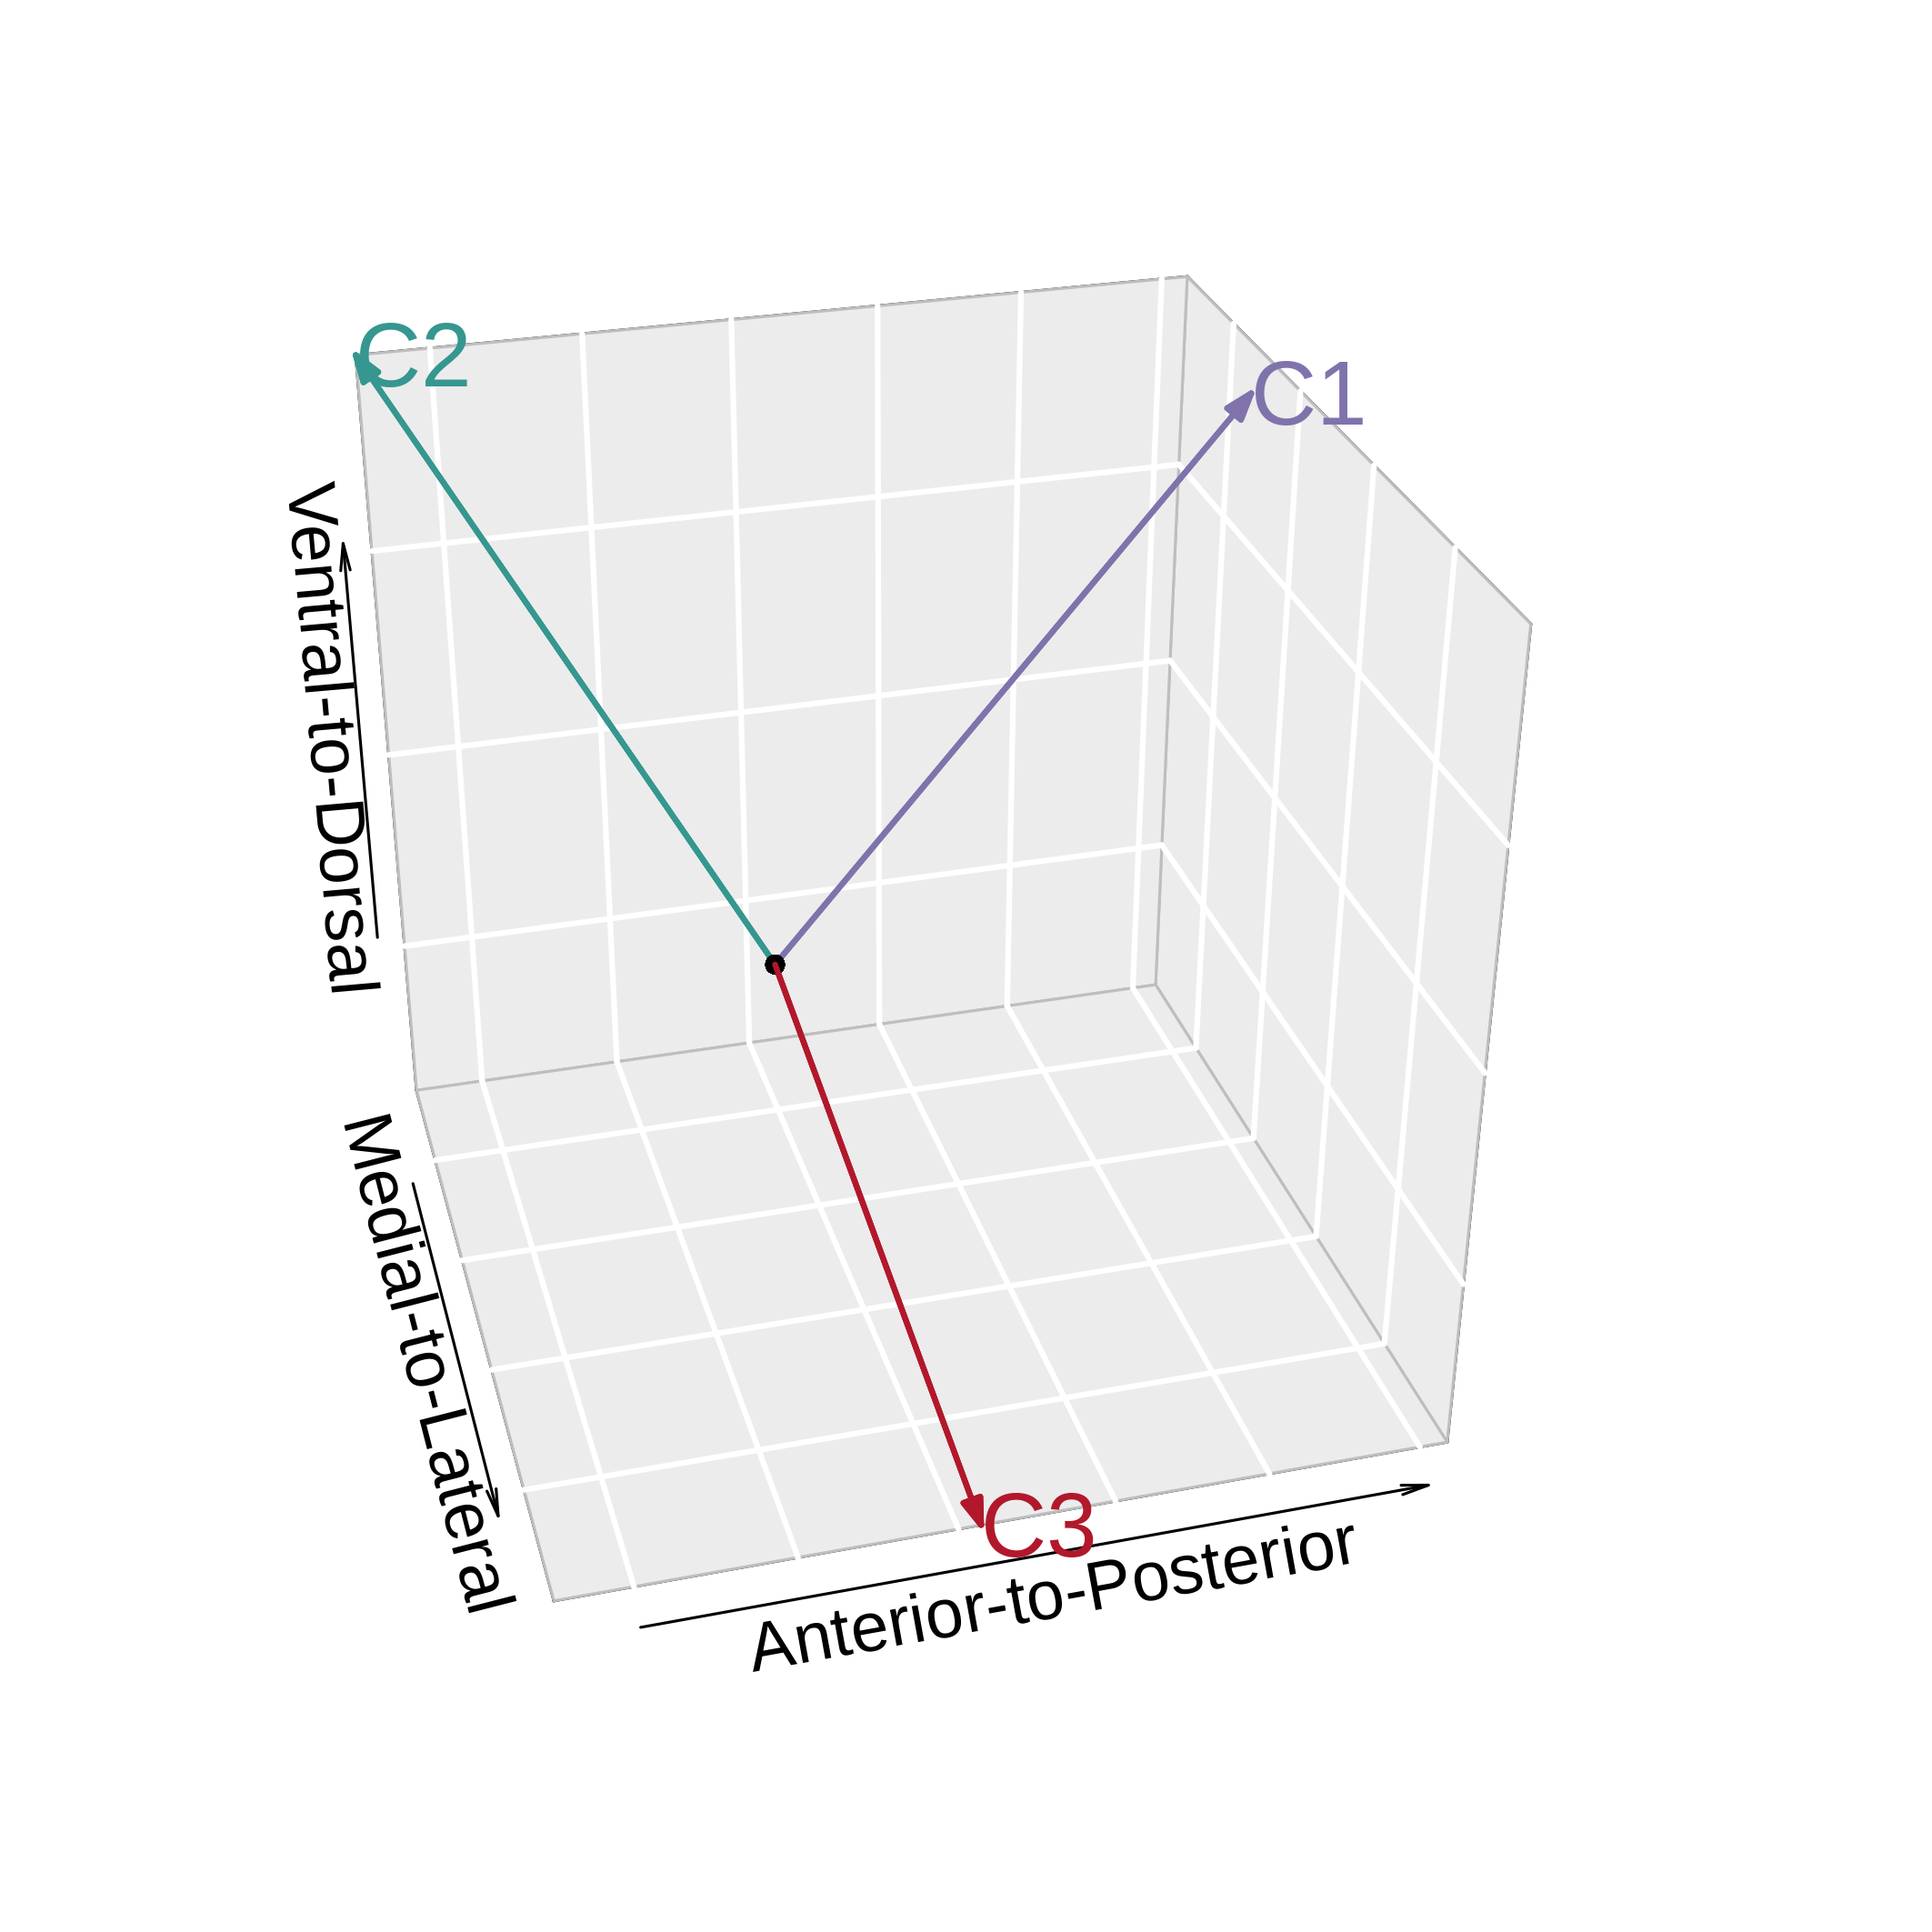

In [13]:
%%R -i xyz_corrs -w 180 -h 180 -u mm -r 300
xyz_corrs['x',] %>% unlist
library(plot3D)
plot_arrows_3d <- function(xyz_corrs) {
    colors <- c(
        brewer.puor(10)[8], brewer.brbg(10)[8], brewer.rdbu(10)[2]
    )

    x0 <- c(0, 0, 0)
    y0 <- c(0, 0, 0)
    z0 <- c(0, 0, 0)
    x1 <- xyz_corrs['x',] %>% unlist
    y1 <- xyz_corrs['y',] %>% unlist # flip AP axis to match left hemisphere
    z1 <- xyz_corrs['z',] %>% unlist
    arrows3D(x0, y0, z0, x1, y1, z1, col = colors,
            lwd = 2, d = 3,
            bty ="g", ticktype = "simple",
            xlab = 'Medial-to-Lateral', ylab = 'Anterior-to-Posterior', zlab = 'Ventral-to-Dorsal',
            phi = 30, theta = 75, cex.lab = 1.5)
    # Add starting point of arrow
    points3D(x0, y0, z0, add = TRUE, col="black", 
            colkey = FALSE, pch = 16, cex = 1)
    # Add labels to the arrows
    text3D(x1, y1, z1, c('C1','C2','C3'),
        col = colors, add=TRUE, colkey = FALSE, cex=2)
}
axes_plot <- plot_arrows_3d(xyz_corrs)
axes_plot

In [15]:
hcp_scores = dme_3d_ds5.clean_scores()

Attaching package: ‘gridExtra’



    combine





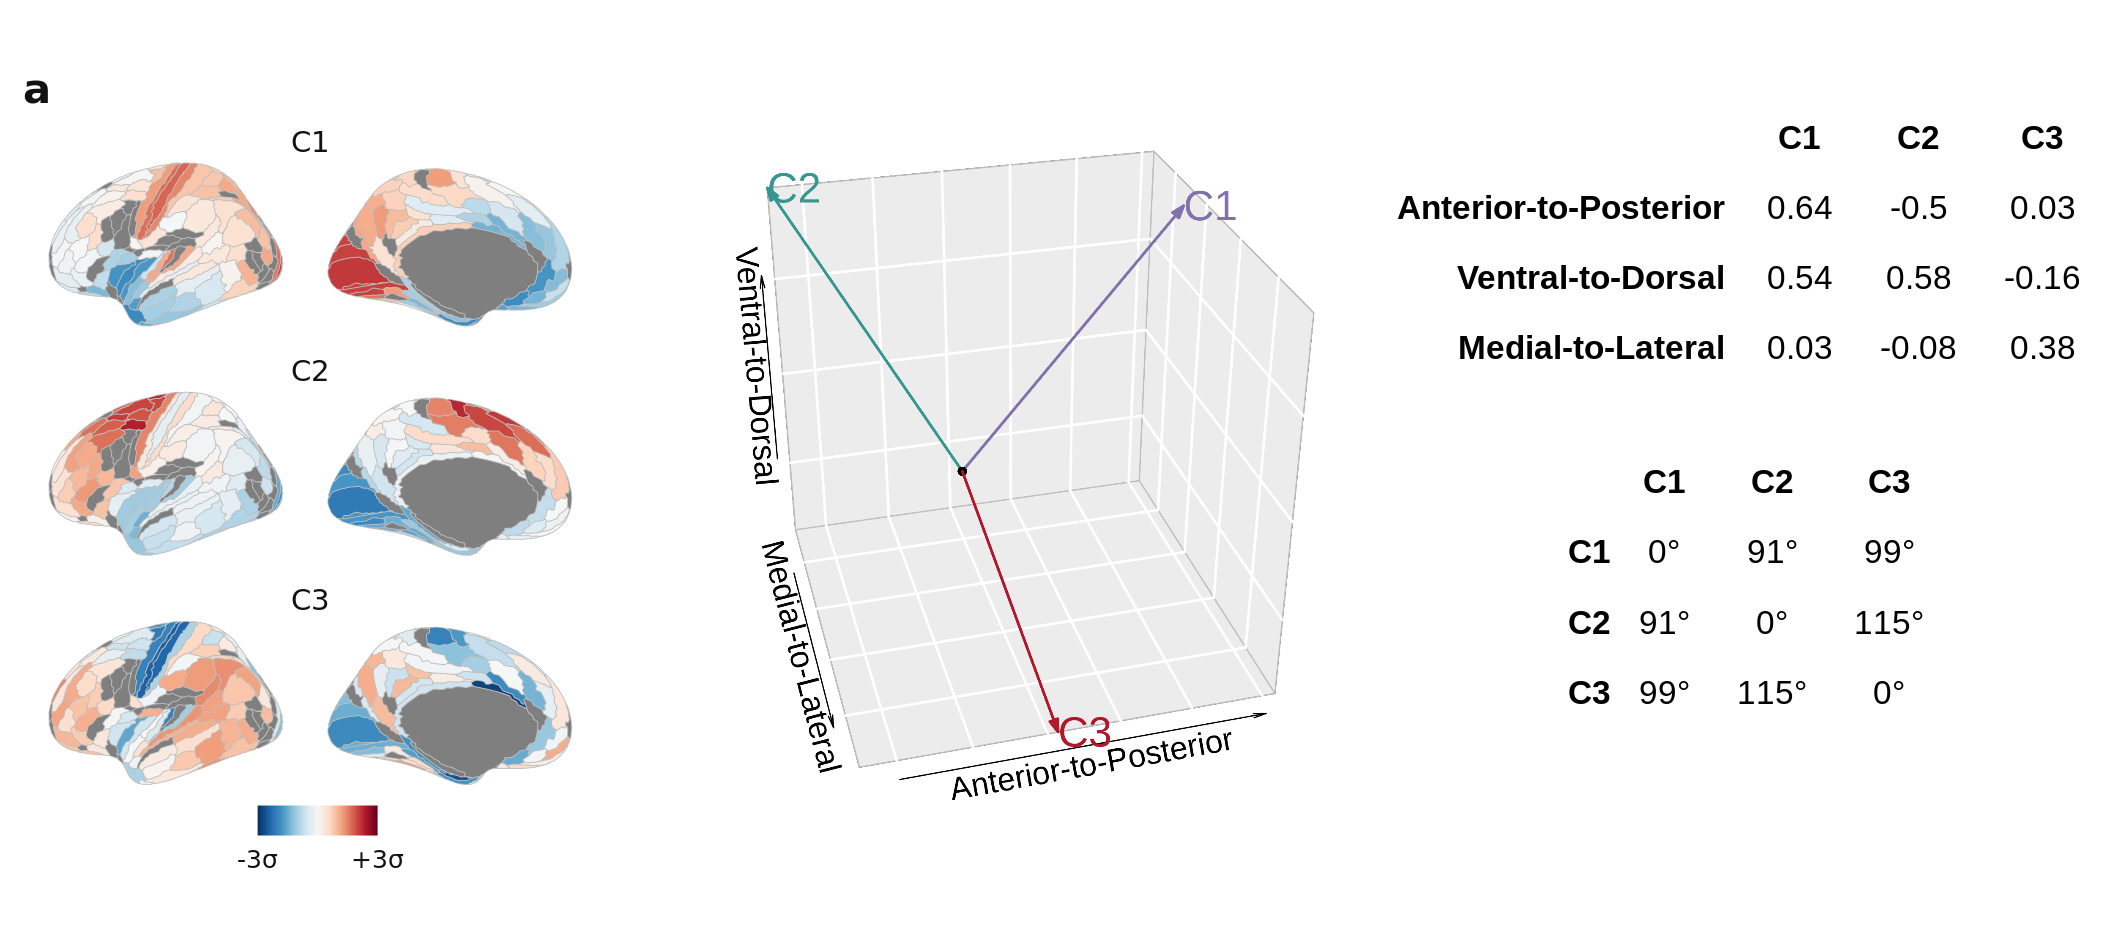

In [16]:
%%R -i hcp_scores -i xyz_corrs_plot -i angles -w 180 -h 80 -u mm -r 300
source("../code/fig_extended.R")

plot_brains <- plot_brains(hcp_scores, strip=TRUE, legend_pos='bottom') + 
                theme(legend.margin=margin(-10,0,0,0,'mm')) + labs(tag='a')

img_path <- "../outputs/axes_plot.png"
img <- readPNG(img_path, native=T)
plot_axes <- ggplot() + inset_element(img, left=0,right=1,top=1,bottom=0, align_to='full') #+ labs(tag='b') + theme(plot.tag.position=c(.2,.95))

# plot_angles <- grid.table(angles, theme = ttheme_minimal(rowhead=list(fg_params=list(fontface='bold'))))
plot_corrs <- gridExtra::tableGrob(xyz_corrs_plot, theme = ttheme_minimal(base_size=8, rowhead=list(fg_params=list(fontface='bold'))))
plot_angles <- gridExtra::tableGrob(angles, theme = ttheme_minimal(base_size=8, rowhead=list(fg_params=list(fontface='bold'))))

design <- c(
    area(t=1,b=90,l=31,r=150),
    area(t=1,b=90,l=1,r=50),
    area(t=1,b=45,l=121,r=180),
    area(t=46,b=70,l=121,r=180)
)

plot_alignments <- plot_axes + plot_brains + plot_corrs + plot_angles + plot_layout(design=design)
plot_alignments

### Region-region coexpression

In [18]:
expression_dict = {
    'original': dme_3d_ds5.expression.apply(lambda x: (x-np.mean(x))/np.std(x)),
    'without C1': regress_out_components(dme_3d_ds5, 1)
}
coexp_dict = {name:get_coexp(expression) for name, expression in expression_dict.items()}

In [19]:
coexp_df = (pd.concat(coexp_dict)
    .melt(ignore_index=False)
    .rename_axis(['version', 'x'], axis=0)
    .set_axis(['y', 'r'], axis=1)
    .reset_index()
)

In [21]:
order = get_coexp(dme_3d_ds5.expression, return_order=True)[1]

coexp_labels = (
    fetch_hcp()['info']
    .set_index('id')
    .loc[order, ['Lobe','cortex','label']]
    .reset_index().reset_index()
    .assign(number = lambda x: 137-x['index'])
    .replace({'Lobe':{
        'Fr':'Frontal',
        'Ins': 'Insula',
        'Occ': 'Occipital',
        'Par': 'Parietal',
        'Temp': 'Temporal'
    }})
)
coexp_labels

,index,id,Lobe,cortex,label,number
0,0,57,Frontal,Anterior_Cingulate_and_Medial_Prefrontal,p24pr,137
1,1,58,Frontal,Anterior_Cingulate_and_Medial_Prefrontal,33pr,136
2,2,59,Frontal,Anterior_Cingulate_and_Medial_Prefrontal,a24pr,135
3,3,60,Frontal,Anterior_Cingulate_and_Medial_Prefrontal,p32pr,134
4,4,61,Frontal,Anterior_Cingulate_and_Medial_Prefrontal,a24,133
...,...,...,...,...,...,...
132,132,135,Temporal,Medial_Temporal,TF,5
133,133,155,Temporal,Medial_Temporal,PHA2,4
134,134,139,Temporal,Temporo-Parieto-Occipital_Junction,TPOJ1,3
135,135,18,Temporal,Ventral_Stream_Visual,FFC,2


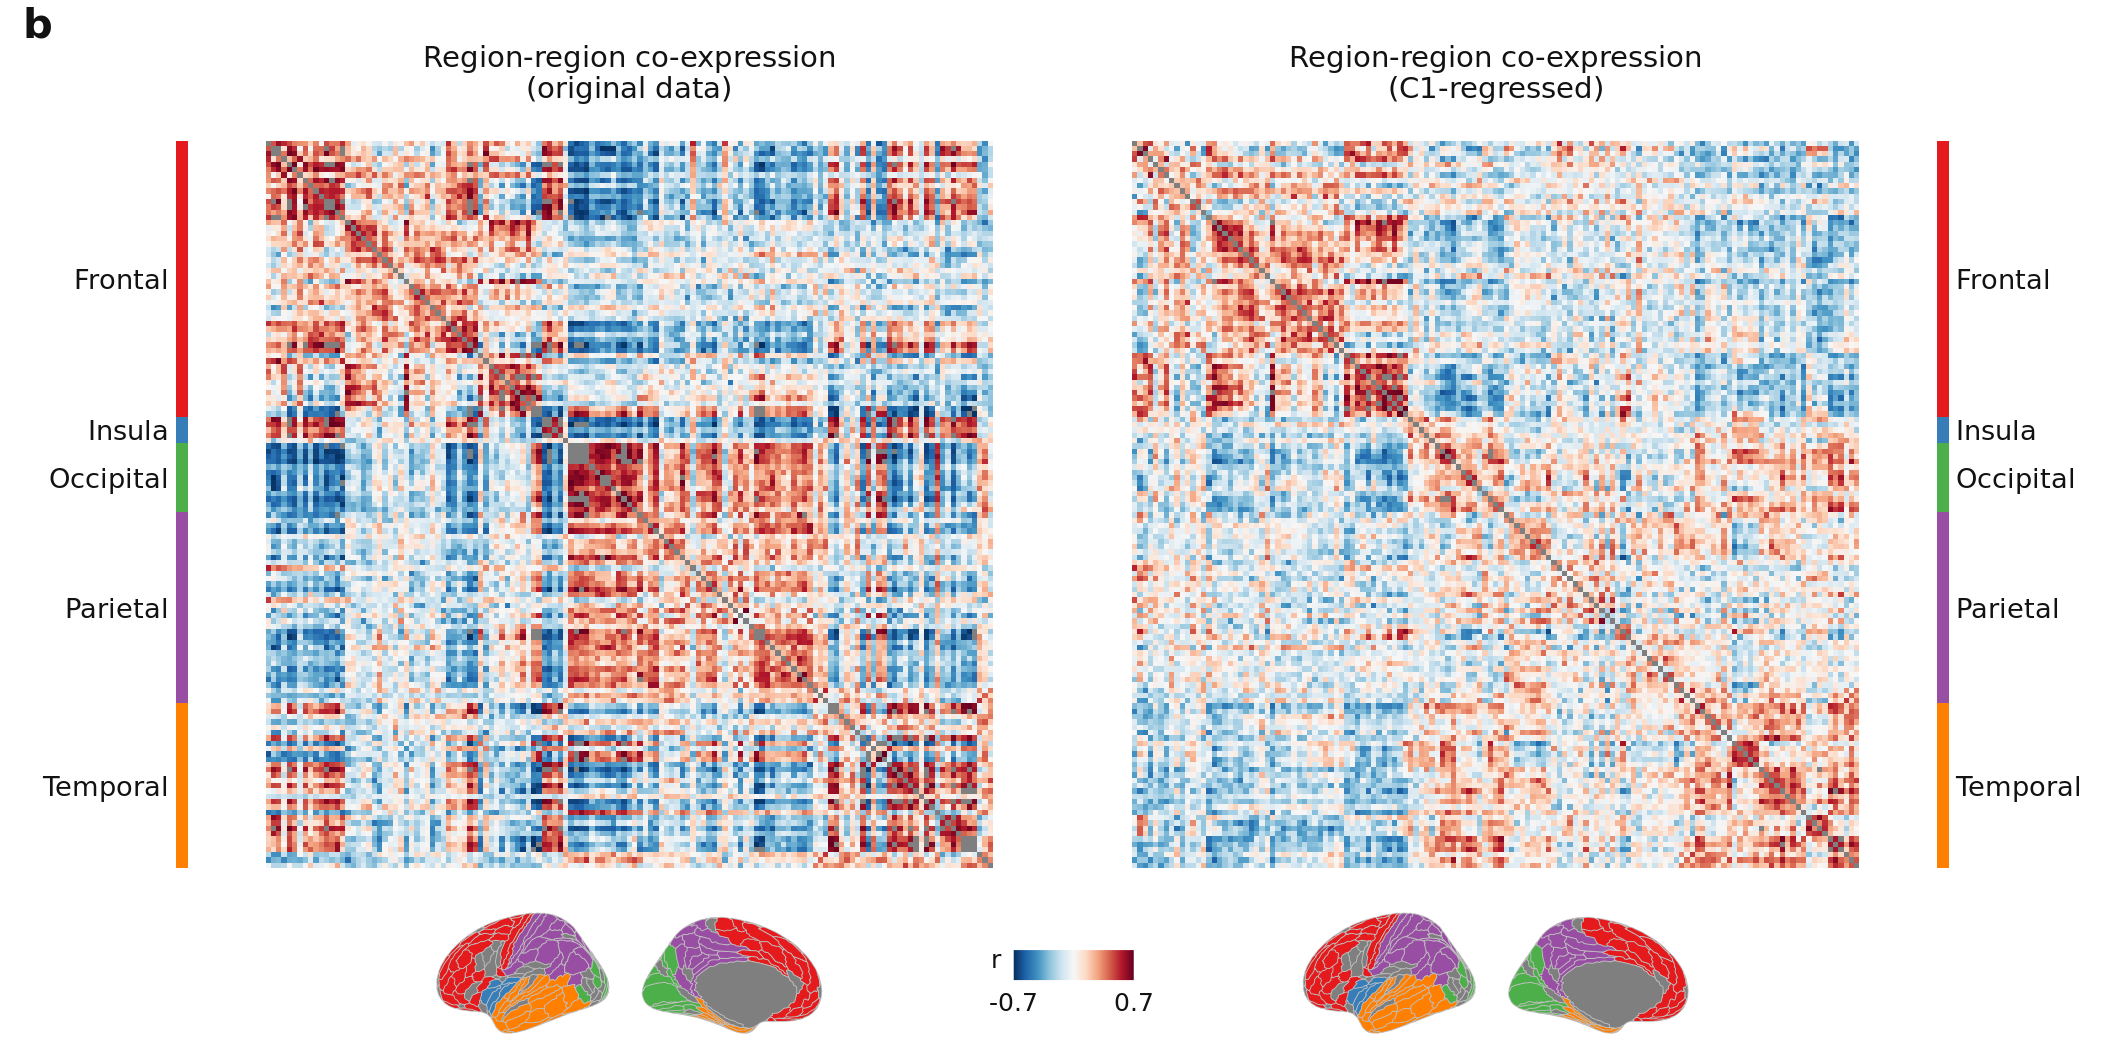

In [22]:
%%R -i coexp_df -i coexp_labels -w 180 -h 90 --units mm -r 300
source("../code/fig_extended.R")

p0 <- coexp_labels %>%
rename(region = label) %>% 
mutate(region = recode(region,'7Pl'='7PL')) %>%
ggseg(
        atlas=glasser,
        position = 'stacked',
        hemi='left',
        mapping=aes(fill=Lobe),
        colour='grey', size=.1,
        show.legend=T
        ) +
    scale_fill_manual(values=brewer.set1(5), guide='none') +
    theme_void()

p1 <- plot_coexp(coexp_df %>% filter(version=='original'), limit=0.7) + 
        ggtitle('Region-region co-expression\n(original data)') + 
        inset_element(p0, top=.13, bottom=0, left=0.2, right=.8, align_to='full')
p2 <- plot_coexp(coexp_df %>% filter(version=='without C1'), limit=0.7) +
        ggtitle('Region-region co-expression\n(C1-regressed)') + 
        inset_element(p0, top=.13, bottom=0, left=0.2, right=.8, align_to='full')
p_labels <- plot_coexp_labels(coexp_labels)
p_labels_flip <- plot_coexp_labels(coexp_labels, flip=TRUE) + labs(tag='b')

plot_networks <- (p_labels_flip | p1 | p2 | p_labels) + plot_layout(widths=c(1,5,5,1), guides='collect')
plot_networks & theme(legend.margin=margin(0,0,2,0,'mm'))

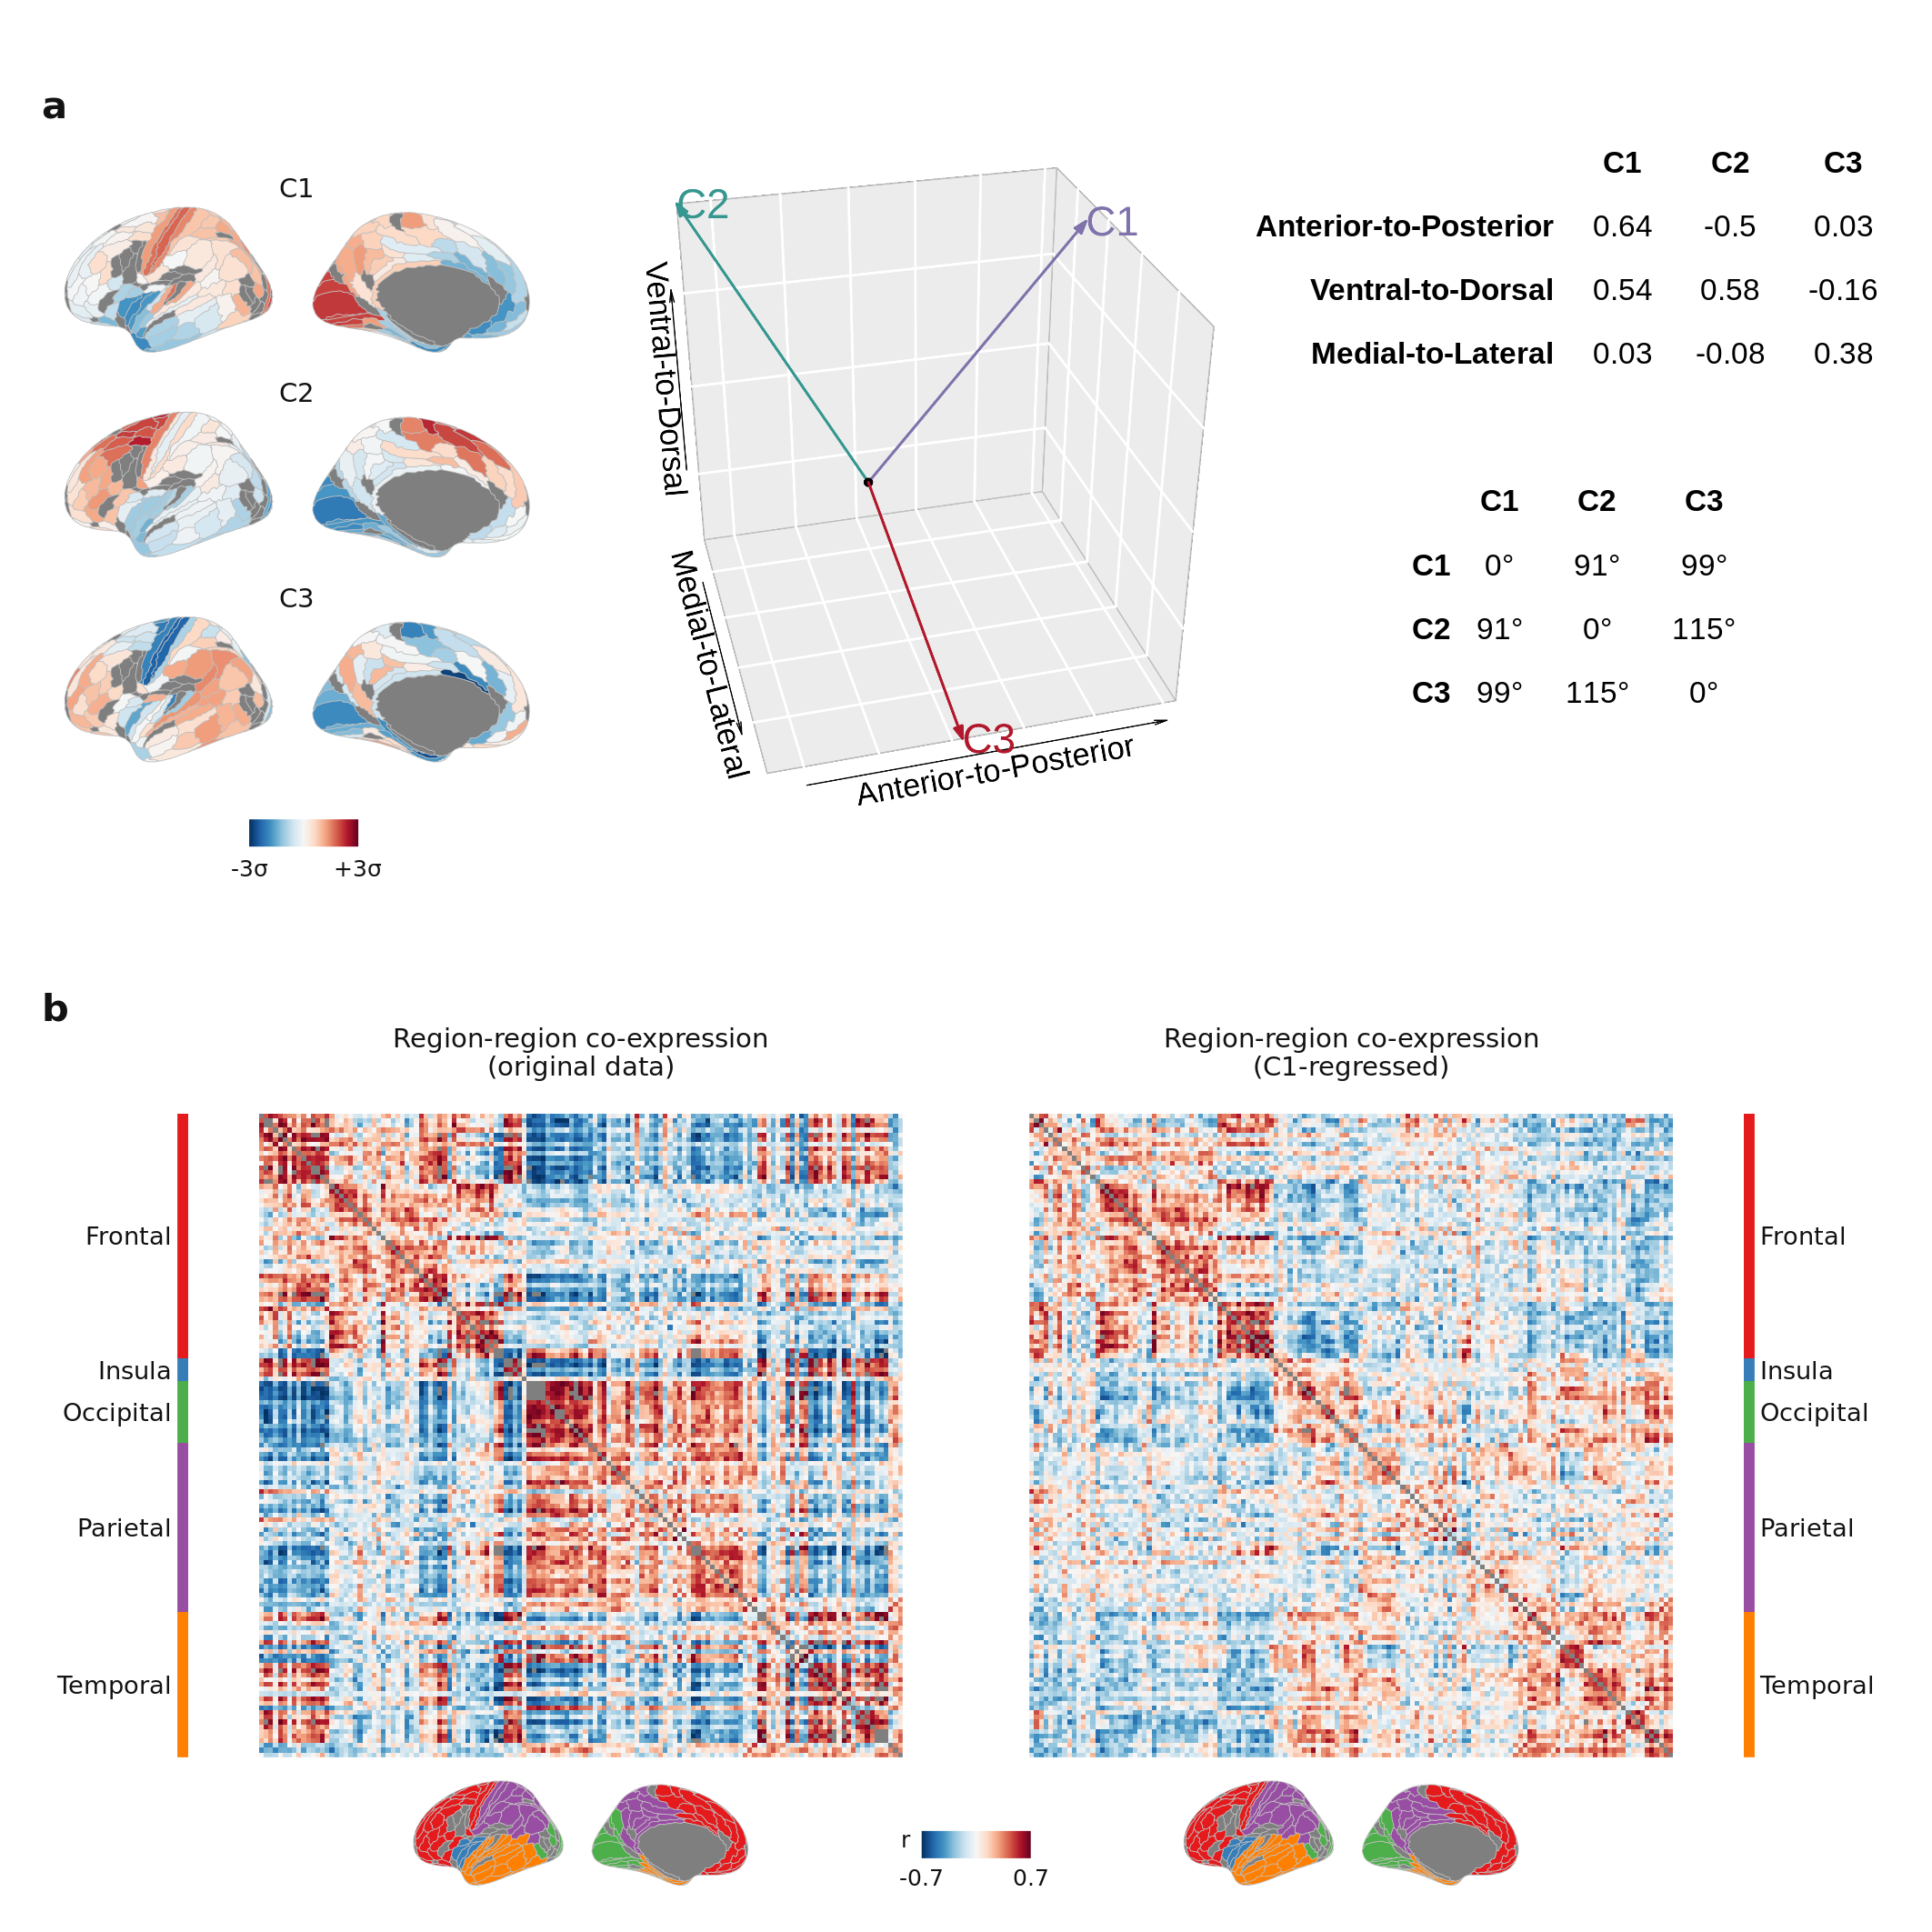

In [25]:
%%R -w 180 -h 180 -u mm -r 300

layout <- c(
    area(t=1,b=90,l=1,r=180),
    area(t=91,b=180,l=1,r=180)
)

plot <- wrap_elements(plot_alignments) + wrap_elements(plot_networks) + plot_layout(design=layout)
annotated <- plot + plot_annotation(theme=theme(plot.margin=margin(0,0,0,0)))
annotated

In [26]:
%%R
ggsave(file="../outputs/figures/fig_ext_4.svg", plot=annotated, width=180, height=180, units='mm')